## FY23 FTA Bus and Low- and No-Emission Grant Awards Analysis

<b>GH issue:</b> 
* Research Request - Bus Procurement Costs & Awards #897

<b>Data source(s):</b> 
1. https://www.transit.dot.gov/funding/grants/fy23-fta-bus-and-low-and-no-emission-grant-awards
2. https://storymaps.arcgis.com/stories/022abf31cedd438b808ec2b827b6faff

<b>Definitions:</b>  
* <u>Grants for Buses and Bus Facilities Program:</u>
    * 49 U.S.C. 5339(b)) makes federal resources available to states and direct recipients to replace, rehabilitate and purchase buses and related equipment and to construct bus-related facilities, including technological changes or innovations to modify low or no emission vehicles or facilities. Funding is provided through formula allocations and competitive grants. 
<br><br>
* <u>Low or No Emission Vehicle Program:</u>
    * 5339(c) provides funding to state and local governmental authorities for the purchase or lease of zero-emission and low-emission transit buses as well as acquisition, construction, and leasing of required supporting facilities.


In [1]:
import pandas as pd
import shared_utils
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy import stats
#set_option to increase max rows displayed to 200, to see entire df in 1 go/
pd.set_option("display.max_rows", 200)


## Reading in raw data from gcs

In [ ]:
df = pd.read_csv(
    "gs://calitp-analytics-data/data-analyses/bus_procurement_cost/data-analyses_bus_procurement_cost_fta_press_release_data_csv.csv"
)

## Data Cleaning
1. snake-case column name
2. currency format funcding column (with $ and , )
3. seperate text from # of bus col (split at '(')
    a. trim spaces in new col
    b. get rid of () characters in new col
4. trim spaces in other columns?

In [ ]:
# snake case columns names via list
new_col = [
    "state",
    "project_sponsor",
    "project_title",
    "description",
    "funding",
    "#_of_buses",
    "project_type",
    "propulsion_type",
    "area_served",
    "congressional_districts",
    "fta_region",
    "bus/low-no_program",
]

df.columns = new_col
df.columns

In [ ]:
# checking data type of funding col
# checking to see if any values are not numbers
# will need to clean up this col
display(df["funding"].dtype,
        df.funding.value_counts()
       )

In [ ]:
#clean up funding column. removing $ and , and making column as int64
df['funding']=df['funding'].str.replace('$','')
df['funding']=df['funding'].str.replace(',','')
df['funding'] = df['funding'].astype('int64')

In [ ]:
#checking to see if str.replace worked.
display(df["funding"].dtype,
        df.head()
       )

In [ ]:
# test of removing the spaces first in # of bus colum, THEN split by (
df["#_of_buses"] = df["#_of_buses"].str.replace(" ", "")

In [ ]:
#spaces removed, and zeros are kept
df['#_of_buses'].value_counts()

In [ ]:
#spliting the # of buses column into 2, using the ( char as the delimiter
df[["bus_count", "bus_desc"]] = df["#_of_buses"].str.split(pat="(", n=1, expand=True)

In [ ]:
#checking col. retained the initial col. and added new columns to the end.
df.columns

In [ ]:
# examining the new bus count col.
#zero values remained the same
# see there are 2 values that are inconsistent.
df.bus_count.value_counts()

In [ ]:
# function to find the row index of a specific value and column in a dataframe
def find_loc(data, col, val):
    x = data.loc[data[col] == val].index[0]
    return x

In [ ]:
loc1 = find_loc(df, "bus_count", "56estimated-cutawayvans")
loc2 = find_loc(df, "bus_count", "12batteryelectric")

In [ ]:
display(loc1, loc2)

In [ ]:
# editing the values of the bus count col at specific location
#syntax, look at ## index, look at XX column
df.loc[58, "bus_count"] = 56
df.loc[32, "bus_count"] = 12

In [ ]:
# updating values again for bus_desc. same location
df.loc[58, "bus_desc"] = "estimated-cutaway vans (PM- award will not fund 68 buses)"
df.loc[32, "bus_desc"] = "battery electric"

In [ ]:
# values updated as inteneded for bus count and bus desc
display(df.loc[32], df.loc[58])

In [ ]:
# confirming via value counts that all values are valid now.
df.bus_count.value_counts()

In [ ]:
# clearning the bus desc col.
# removing the )
df["bus_desc"] = df["bus_desc"].str.replace(")", "")

In [ ]:
df["bus_desc"].unique()

In [ ]:
# stripping the values in the bus desc col
df["bus_desc"] = df["bus_desc"].str.strip()

In [ ]:
df.bus_desc.unique()

In [ ]:
# creating a dictionary to add spaces back to the values
new_dict = {
    "beb": "BEB",
    "estimated-CNGbuses": "estimated-CNG buses",
    "cngbuses": "CNG buses",
    "BEBs": "BEB",
    "Electric\n16(Hybrid": "15 electic, 16 hybrid",
    "FuelCellElectric": "fuel cell electric",
    "FuelCell": "fuel cell",
    "lowemissionCNG": "low emission CNG",
    "cng": "CNG",
    "BEBsparatransitbuses": "BEBs paratransit buses",
    "hybridelectric": "hybrid electric",
    "zeroemissionbuses": "zero emission buses",
    "dieselelectrichybrids": "diesel electric hybrids",
    "hydrogenfuelcell": "hydrogen fuel cell",
    "2BEBsand4HydrogenFuelCellBuses": "2 BEBs and 4 hydrogen fuel cell buses",
    "4fuelcell/3CNG": "4 fuel cell / 3 CNG",
    "hybridelectricbuses": "hybrid electric buses",
    "CNGfueled": "CNG fueled",
    "zeroemissionelectric": "zero emission electric",
    "hybridelectrics": "hybrid electrics",
    "dieselandgas": "diesel and gas",
    "diesel-electrichybrids": "diesel-electric hybrids",
    "propanebuses": "propane buses",
    "1:CNGbus;2cutawayCNGbuses": "1:CNGbus ;2 cutaway CNG buses",
    "zeroemission": "zero emission",
    "propanedpoweredvehicles": "propaned powered vehicles"
}

In [ ]:
#using new dictionary to replace values in the bus desc col
df.replace({'bus_desc': new_dict}, inplace=True)

In [ ]:
#confirming the bus desc values were replaced as indeded.
list(df.bus_desc.unique())

In [ ]:
#bus count for row 12 needs to be adjusted to 31 instead of 15
df.loc[12, "bus_count"] = 31

In [ ]:
#confirming the change
df.loc[12]

In [ ]:
#using str.lower() on project type 
df['project_type'] = df['project_type'].str.lower()

In [ ]:
#using str.lower() on project type 
df['project_type'] = df['project_type'].str.replace(' ','')

In [ ]:
#confirming lower and replace worked as intended
list(df['project_type'].sort_values(ascending=True).unique())

In [ ]:
#some values still need to get adjusted. will use a short dictionary to fix
new_type={'\tbus/facility':'bus/facility',
          'bus/facilitiy':'bus/facility',
          'facilities':'facility',
}

In [ ]:
#using replace() with the dictionary to replace keys in project type col
#syntax df.replace({'bus_desc': new_dict}, inplace=True)
df.replace({'project_type': new_type}, inplace=True)

In [ ]:
#double checking to ensure dictionary reaplce works.
list(df['project_type'].sort_values(ascending=True).unique())

## Exporting cleaned data to GCS

In [ ]:
#saving to GCS as csv
df.to_csv('gs://calitp-analytics-data/data-analyses/bus_procurement_cost/fta_bus_cost_clean.csv')

## Reading in cleaned data from GCS

In [ ]:
bus_cost = pd.read_csv('gs://calitp-analytics-data/data-analyses/bus_procurement_cost/fta_bus_cost_clean.csv')

In [ ]:
#confirming cleaned data shows as expected.
display(bus_cost.shape,
        type(bus_cost),
    bus_cost.columns
       )

In [ ]:
#drop unnessary columns
bus_cost = bus_cost.drop(['Unnamed: 0', 'congressional_districts'], axis=1)

In [ ]:
#confirming columns dropped as intended.
#less columns(14 to 12)
display(bus_cost.shape,
        bus_cost.columns)

## Cost per Bus, per Transit Agency

In [ ]:
only_bus.head()

In [ ]:
cost_per_bus = only_bus.groupby('project_sponsor').agg({
    'funding':'sum',
    'bus_count':'sum'
}).reset_index()

In [ ]:
cost_per_bus['cost_per_bus'] = (cost_per_bus['funding']/cost_per_bus['bus_count']).astype('int64')

In [ ]:
cost_per_bus.dtypes

In [ ]:
cost_per_bus

In [ ]:
## export cost_per_bus df to gcs
cost_per_bus.to_csv('gs://calitp-analytics-data/data-analyses/bus_procurement_cost/fta_cost_per_bus.csv')

## Cost per bus, stats analysis

In [2]:
#read in fta cost per bus csv
cost_per_bus = pd.read_csv('gs://calitp-analytics-data/data-analyses/bus_procurement_cost/fta_cost_per_bus.csv')

In [4]:
display(cost_per_bus.shape,
        cost_per_bus.head()
       )

(95, 5)

,Unnamed: 0,project_sponsor,funding,bus_count,cost_per_bus
0,0,AUTORIDAD METROPOLITANA DE AUTOBUSES (PRMBA),10000000,8,1250000
1,1,Alameda-Contra Costa Transit District,25513684,25,1020547
2,2,Berkshire Regional Transit Authority,2212747,2,1106373
3,3,Brazos Transit District,9650646,11,877331
4,4,Cape Fear Public Transportation Authority,2860250,5,572050


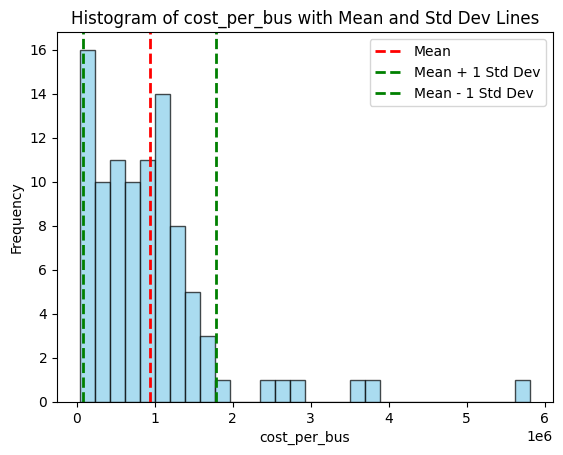

In [19]:
# Assuming your DataFrame is named df
cost_per_bus_values = cost_per_bus['cost_per_bus']

# Calculate mean and standard deviation
mean_value = cost_per_bus_values.mean()
std_deviation = cost_per_bus_values.std()

# Plot histogram
plt.hist(cost_per_bus_values, bins=30, color='skyblue', edgecolor='black', alpha=0.7)

# Add vertical lines for mean and standard deviation
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(mean_value + std_deviation, color='green', linestyle='dashed', linewidth=2, label='Mean + 1 Std Dev')
plt.axvline(mean_value - std_deviation, color='green', linestyle='dashed', linewidth=2, label='Mean - 1 Std Dev')

# Set labels and title
plt.xlabel('cost_per_bus')
plt.ylabel('Frequency')
plt.title('Histogram of cost_per_bus with Mean and Std Dev Lines')
plt.legend()

# Show the plot
plt.show()

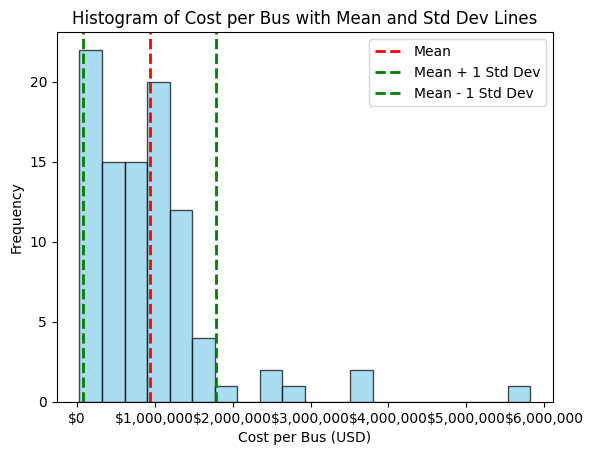

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Assuming your DataFrame is named df
cost_per_bus_values = cost_per_bus['cost_per_bus']

# Calculate mean and standard deviation
mean_value = cost_per_bus_values.mean()
std_deviation = cost_per_bus_values.std()

# Plot histogram
plt.hist(cost_per_bus_values, bins=20, color='skyblue', edgecolor='black', alpha=0.7)

# Add vertical lines for mean and standard deviation
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(mean_value + std_deviation, color='green', linestyle='dashed', linewidth=2, label='Mean + 1 Std Dev')
plt.axvline(mean_value - std_deviation, color='green', linestyle='dashed', linewidth=2, label='Mean - 1 Std Dev')

# Set labels and title
plt.xlabel('Cost per Bus (USD)')
plt.ylabel('Frequency')
plt.title('Histogram of Cost per Bus with Mean and Std Dev Lines')
plt.legend()

# Format x-axis ticks as USD
plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))

# Show the plot
plt.show()


## Initial Summary Stats

### Summary Stats

In [ ]:
#top level alanysis

bus_cost.agg({'project_title':'count',
              'funding':'sum',
              'bus_count':'sum'}
              )

In [ ]:
#start of agg. by project_type

bus_cost.groupby('project_type').agg({
    'project_type': 'count',
    'funding': 'sum',
    'bus_count':'sum'
})

In [ ]:
#agg by program

bus_cost.groupby('bus/low-no_program').agg({
    'project_type': 'count',
    'funding': 'sum',
    'bus_count':'sum'
})

In [ ]:
#agg by state, by funding
bus_cost.groupby('state').agg({
    'project_type': 'count',
    'funding': 'sum',
    'bus_count':'sum'
}).sort_values(by='funding', ascending=False)

### Projects with bus purchases

In [ ]:
#df of only projects with a bus count
only_bus=bus_cost[bus_cost['bus_count']>0]

In [ ]:
display(only_bus.shape,
        only_bus.columns)

In [ ]:
#agg by propulsion type
only_bus['propulsion_type'].value_counts()

In [ ]:
only_bus.project_type.value_counts()

In [ ]:
#of the rows with bus_count >1, what are the project types?
bus_agg = only_bus.groupby('project_type').agg({
    'project_type': 'count',
    'funding': 'sum',
    'bus_count':'sum'
})

In [ ]:
#new column that calculates `cost per bus`
bus_agg['cost_per_bus']=(bus_agg['funding']/bus_agg['bus_count']).astype('int64')

In [ ]:
bus_agg

### Projects with no buses

In [ ]:
no_bus=bus_cost[bus_cost['bus_count']<1]

In [ ]:
no_bus['project_type'].value_counts()

## Overall Summary

In [ ]:
project_count=bus_cost.project_title.count()
fund_sum=bus_cost.funding.sum()
bus_count_sum=bus_cost.bus_count.sum()
overall_cost_per_bus = (fund_sum)/(bus_count_sum)
bus_program_count=bus_cost['bus/low-no_program'].value_counts()

projects_with_bus=only_bus.project_title.count()
projects_with_bus_funds=only_bus.funding.sum()
cost_per_bus = (only_bus.funding.sum())/(bus_count_sum)

In [ ]:
summary = f'''
Top Level observation:
- {project_count} projects awarded
- ${fund_sum:,.2f} dollars awarded
- {bus_count_sum} buses to be purchased
- ${overall_cost_per_bus:,.2f} overall cost per bus

Projects have some mix of buses, facilities and equipment. Making it difficult to disaggregate actual bus cost.

Of the {project_count} projects awarded, {projects_with_bus} projects inlcuded buses. The remainder were facilities, chargers and equipment

Projects with buses purchases:
- {projects_with_bus} projects
- ${projects_with_bus_funds:,.2f} awarded to purchases buses
- ${cost_per_bus:,.2f} cost per bus
'''

In [ ]:
print(summary)